# Solution 3: Computing path lengths of taxi trips

This notebook is a solution to the problem posed in [exercises/exercise-3-EVALUATED.ipynb](../exercises/exercise-3-EVALUATED.ipynb).

Don't peek at this until you've tried to solve it!

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import awkward._v2 as ak

## Reading the dataset

For brevity, let's load the dataset with only the columns we need.

In [2]:
taxi = ak.from_parquet(
    "https://zenodo.org/records/14537442/files/chicago-taxi.parquet",
    columns=["trip.km", "trip.begin.l*", "trip.path.*"],
    row_groups=[0],
)
taxi.show(type=True)

type: 353 * var * ?{
    trip: {
        km: ?float32,
        begin: {
            lon: ?float64,
            lat: ?float64
        },
        path: var * {
            londiff: float32,
            latdiff: float32
        }
    }
}
[[{trip: {km: 0, begin: {lon: -87.7, ...}, path: [...]}}, {...}, ..., {...}],
 [{trip: {km: 0, begin: {lon: -87.7, ...}, path: [...]}}, {...}, ..., {...}],
 [{trip: {km: 0.966, begin: {lon: -87.6, ...}, path: [...]}}, ..., {...}],
 [{trip: {km: 1.29, begin: {lon: -87.6, ...}, path: [...]}}, {...}, ..., {...}],
 [{trip: {km: 0, begin: {lon: -87.7, ...}, path: [...]}}, {...}, ..., {...}],
 [{trip: {km: 29.6, begin: {lon: -87.9, ...}, path: [...]}}, {...}, ..., {...}],
 [{trip: {km: 29.1, begin: {lon: -87.9, ...}, path: [...]}}, {...}, ..., {...}],
 [],
 [{trip: {km: 2.74, begin: {lon: -87.6, ...}, path: [...]}}, {...}, ..., {...}],
 [{trip: {km: 0, begin: {lon: -87.7, ...}, path: [...]}}, {...}, ..., {...}],
 ...,
 [{trip: {km: 0.966, begin: {lon: -87.6, ..

## Longitude, latitude → kilometers

Reproducing the conversion from longitude, latitude differences to absolute positions to kilometers.

In [3]:
all_longitudes = taxi.trip.begin.lon + taxi.trip.path.londiff
all_latitudes = taxi.trip.begin.lat + taxi.trip.path.latdiff

all_longitudes.show()

[[[-87.7, -87.7], [-87.7, -87.7, ..., -87.7, -87.7], ..., [-87.7, -87.7]],
 [[-87.7, -87.7], [-87.7, -87.7], ..., [-87.9, -87.9, ..., -87.7, -87.7], []],
 [[-87.6, -87.6, -87.6, -87.6, -87.6, -87.6, -87.6], [-87.6, ...], ..., None],
 [[-87.6, -87.6, -87.6, -87.6, -87.6, -87.6], ..., [-87.6, -87.6, ..., -87.7]],
 [[-87.7, -87.7], ..., [-87.6, -87.6, -87.6, -87.6, -87.6, -87.6, -87.6]],
 [[-87.9, -87.9, -87.9, -87.9, -87.9, ..., -87.6, -87.6, -87.6, -87.6], ...],
 [[-87.9, -87.9, -87.9, -87.9, -87.9, ..., -87.6, -87.6, -87.6, -87.6], ...],
 [],
 [[-87.6, -87.6, -87.6, -87.6, -87.6, ..., -87.7, -87.7, -87.7, -87.7], ...],
 [[-87.7, -87.7], ..., [-87.6, -87.6, -87.6, -87.6, ..., -87.7, -87.7, -87.7]],
 ...,
 [[-87.6, -87.6, -87.6, -87.6, -87.6, -87.6], ..., [-87.6, -87.6, ..., -87.6]],
 [None, None, None, None, None, None, None],
 [None, None, None, None, None, None, ..., None, None, None, None, None, None],
 [None, None, None, None, None, None, ..., None, None, None, None, None, None],
 [

In [4]:
LONGITUDE, LATITUDE = -87.66178320769112, 41.896777262111726   # mean position (center of town)
LON_TO_KM, LAT_TO_KM = 82.98452409203695, 111.07127961503745   # lon, lat → km conversion factors

In [5]:
km_east, km_north = (
    (all_longitudes - LONGITUDE) * LON_TO_KM,
    (all_latitudes - LATITUDE) * LAT_TO_KM,
)
km_east, km_north

(<Array [[[-4.63, -4.63], ..., [...]], ...] type='353 * var * option[var * f...'>,
 <Array [[[5.12, 5.12], ..., [10, ...]], ...] type='353 * var * option[var *...'>)

## Single path example for comparison

This imperative `for` loop calculation on a single path was given in the problem statement.

I'm repeating it here so that we can compare it with the final answer (always a good idea!).

In [6]:
example_east, example_north = (
    km_east[75, -2],
    km_north[75, -2],
)
example_east, example_north

(<Array [-0.143, -0.143, 0.828, 1.21, ..., 3.51, 3.61, 3.62] type='16 * float64'>,
 <Array [-2.53, -2.52, -2.49, ..., -6.48, -6.48, -6.85] type='16 * float64'>)

In [7]:
length = 0
for i in range(len(example_east) - 1):
    Δx = example_east[i + 1] - example_east[i]
    Δy = example_north[i + 1] - example_north[i]
    Δr = np.sqrt(Δx**2 + Δy**2)
    length += Δr

length

7.30448400458981

## THE SOLUTION

Here is a one-line calculation of all the distances of all the paths, maintaining path structure.

In [8]:
distances = ak.sum(np.sqrt((km_east[:, :, 1:] - km_east[:, :, :-1])**2 + (km_north[:, :, 1:] - km_north[:, :, :-1])**2), axis=-1)

It has the right type: only a single `var` (same as `trips.km`).

In [9]:
distances.type.show()

353 * var * ?float64


Here are the values that were provided for comparison, to help you know if you got it right.

In [10]:
distances.show()

[[0, 9.63, 6.2, 2.07, 10.1, 0, 1.21, ..., 1.34, 12.2, 6.27, 2.58, 7.27, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 3.56, None, ..., 0, 24.5, 0, 6.22, 2.26, 7.24, 22.1, 0],
 [1.75, 4.82, 3.71, 2.86, 6.41, 6.89, ..., 2.72, 3.65, 28.3, 0, 24.8, None],
 [1.17, 2.39, 1.07, 4.85, 2.95, 2.78, ..., 0.899, 2.61, 2.22, 1.43, 11.9, 3.65],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 22.9, 23.4, 0, 0, 20.5, 22.9, 23.2, 3.09],
 [29, 2.25, 2.91, 0, 27.9, 16.7, 21.1, ..., 2.49, 0, 14.5, 0, 0, 23.6, 3.44],
 [27.5, 1.59, 1.36, 1.48, 2.46, 1.24, ..., 4.43, 6.22, 26.9, None, 0, 1.24],
 [],
 [4.67, 6.23, 1.35, 4.36, 0, 20.9, 0, ..., 26.9, 23.1, None, 20, 0, 16.6, 21.4],
 [0, 0, 0, 0, 0, 0, 0, 2.88, ..., 14.9, 19.9, 17.8, 9.15, 10.6, 12.2, 16.5, 14],
 ...,
 [1.52, 1.93, 5.76, 5.76, 2.95, 0, ..., 4.18, 1.45, 26.9, 3.55, 4.69, 2.92],
 [None, None, None, None, None, None, None],
 [None, None, None, None, None, None, ..., None, None, None, None, None, None],
 [None, None, None, None, None, None, ..., None, None, None, None, None, Non

And here's the one distance that had been calculated with a `for` loop. It agrees.

In [11]:
distances[75, -2]

7.30448400458981

## As the crow flies solution

There are two ways we could do this, but let's use the padding method.

The answer to

> How would you apply this technique to _deeply_ nested lists?

for both techniques is to use `axis=-1`.

In [12]:
pad_km_east = ak.fill_none(ak.pad_none(km_east, 2, axis=-1), 0, axis=-1)
pad_km_north = ak.fill_none(ak.pad_none(km_north, 2, axis=-1), 0, axis=-1)

The "as the crow flies" solution is similar to the main problem, except that there's no `ak.sum` over segments. It's a single segment from item `-1` to item `0`.

In [13]:
crow_flies = np.sqrt((pad_km_east[:, :, -1] - pad_km_east[:, :, 0])**2 + (pad_km_north[:, :, -1] - pad_km_north[:, :, 0])**2)
crow_flies.show()

[[0, 7.82, 4.91, 1.64, 7.9, 0, 0.688, ..., 0.941, 10.4, 5.07, 2.09, 5.53, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 2.15, None, ..., 0, 20.9, 0, 5.22, 1.62, 6.67, 20.8, 0],
 [1.06, 3.82, 2.6, 2.06, 5.12, 6.54, 1.19, ..., 2.41, 3, 25.6, 0, 22.6, None],
 [0.799, 1.59, 0.858, 3.29, 2.46, 2.02, ..., 1.87, 1.58, 1.12, 9.84, 3.08],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 21.1, 20.2, 0, 0, 18.7, 21.1, 19.3, 2.38],
 [25.6, 1.56, 2.49, 0, 19.8, 15.4, 18.3, ..., 2.36, 0, 12.4, 0, 0, 21.9, 3.04],
 [24.9, 0.923, 0.908, 1.07, 1.92, 0.953, ..., 3.22, 5.22, 24.3, None, 0, 0.953],
 [],
 [3.59, 4.4, 0.88, 3.42, 0, 14, 0, ..., 24.3, 16.4, None, 17, 0, 14.3, 17.6],
 [0, 0, 0, 0, 0, 0, 0, 2.4, ..., 17.8, 15.8, 7.14, 9.54, 11.5, 12.1, 12.6],
 ...,
 [0.711, 1.36, 5.28, 5.28, 2.46, 0, ..., 3.21, 0.961, 24.5, 3.05, 4.53, 2.72],
 [None, None, None, None, None, None, None],
 [None, None, None, None, None, None, ..., None, None, None, None, None, None],
 [None, None, None, None, None, None, ..., None, None, None, None, None, None

## Plotting differences with the `trip.km` field

The plotting code was given, including the hint of filling missing values with `0` (so that `distances` and `taxi.trip.km` align) and flattening.

Here are the full distances on the horizontal axis and `trip.km` on the vertical axis.

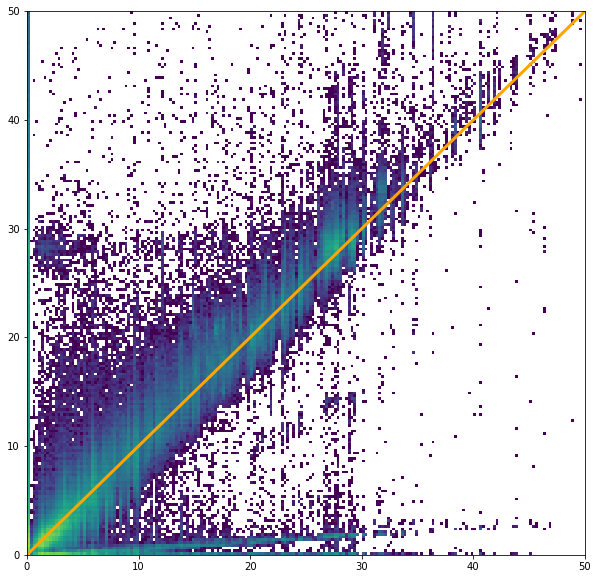

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist2d(
    ak.flatten(ak.fill_none(distances, 0)),    # None → 0 on the plot
    ak.flatten(ak.fill_none(taxi.trip.km, 0)), # None → 0 on the plot
    bins=(200, 200),
    range=((0, 50), (0, 50)),
    norm=matplotlib.colors.LogNorm(),
);
ax.plot([0, 50], [0, 50], c="orange", lw=3);

Here are "as the crow flies" distances on the horizontal axis and `trip.km` on the vertical axis.

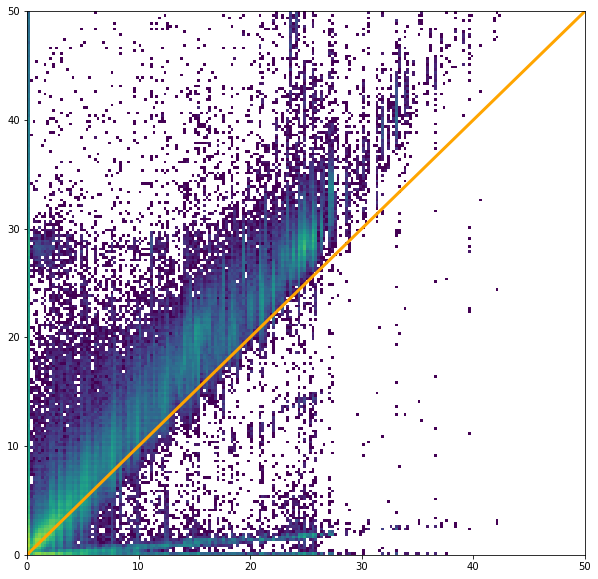

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist2d(
    ak.flatten(ak.fill_none(crow_flies, 0)),   # None → 0 on the plot
    ak.flatten(ak.fill_none(taxi.trip.km, 0)), # None → 0 on the plot
    bins=(200, 200),
    range=((0, 50), (0, 50)),
    norm=matplotlib.colors.LogNorm(),
);
ax.plot([0, 50], [0, 50], c="orange", lw=3);

We should not be surprised that the full path calculations are a better match to reported `trip.km` measurements.

The "as the crow flies" are more fictional: cars don't drive that way.

<img src="../img/as-the-crow-flies.svg" width="500">

However, there are some interesting features on this plot that _I do not understand._

   * There's an island of `trip.km` $\approx$ 29 km with calculated distances $\approx$ 3 km.
   * There's a secondary trend of `trip.km` $\approx$ `distance / 15` along the bottom of each plot. What could that be?

Fun with real data!